# Day 2: Volatility & Technical Features

## Learning Objectives
- Build volatility features (rolling, Parkinson, GARCH-like)
- Create technical indicators (RSI, MACD, Bollinger)
- Volume-based features

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

print("✅ Libraries loaded!")
print("📚 Day 2: Volatility & Technical Features")

✅ Libraries loaded!
📚 Day 2: Volatility & Technical Features


In [2]:
# ============================================================
# GENERATE OHLCV DATA
# ============================================================

print("GENERATING OHLCV DATA")
print("="*60)

np.random.seed(42)
n_days = 1000

# Simulate with volatility clustering
returns = []
vol = 0.015
for i in range(n_days):
    if i > 0:
        vol = 0.9 * vol + 0.1 * abs(returns[-1]) + 0.01 * np.random.normal(0, 0.005)
        vol = np.clip(vol, 0.005, 0.04)
    returns.append(np.random.normal(0.0002, vol))

returns = np.array(returns)
prices = 100 * np.cumprod(1 + returns)

# Create OHLC
df = pd.DataFrame({
    'close': prices,
    'returns': returns,
    'high': prices * (1 + np.abs(np.random.randn(n_days) * 0.008)),
    'low': prices * (1 - np.abs(np.random.randn(n_days) * 0.008)),
    'open': prices * (1 + np.random.randn(n_days) * 0.004),
    'volume': 1e6 * (1 + 0.5 * np.abs(returns) / np.std(returns) + 0.2 * np.random.randn(n_days))
})
df['volume'] = np.maximum(df['volume'], 1e5)

print(f"Data: {len(df)} days")

GENERATING OHLCV DATA
Data: 1000 days


## Part 1: Volatility Features

In [3]:
# ============================================================
# VOLATILITY FEATURES
# ============================================================

print("VOLATILITY FEATURES")
print("="*60)

# Standard rolling volatility
for period in [5, 10, 20, 60]:
    df[f'vol_{period}d'] = df['returns'].rolling(period).std() * np.sqrt(252)

# Parkinson volatility (uses high-low)
df['parkinson_vol'] = np.sqrt(
    (1 / (4 * np.log(2))) * 
    (np.log(df['high'] / df['low'])**2).rolling(20).mean()
) * np.sqrt(252)

# Garman-Klass volatility
df['gk_vol'] = np.sqrt(
    0.5 * (np.log(df['high'] / df['low'])**2).rolling(20).mean() -
    (2 * np.log(2) - 1) * (np.log(df['close'] / df['open'])**2).rolling(20).mean()
) * np.sqrt(252)

# Volatility of volatility
df['vol_of_vol'] = df['vol_20d'].rolling(20).std()

# Volatility ratio (regime indicator)
df['vol_ratio'] = df['vol_5d'] / df['vol_60d']

# Volatility percentile
df['vol_percentile'] = df['vol_20d'].rolling(252).apply(
    lambda x: (x.iloc[-1] > x).mean() if len(x) > 1 else 0.5
)

print("Created volatility features:")
for col in df.columns:
    if 'vol' in col:
        print(f"  • {col}")

VOLATILITY FEATURES
Created volatility features:
  • volume
  • vol_5d
  • vol_10d
  • vol_20d
  • vol_60d
  • parkinson_vol
  • gk_vol
  • vol_of_vol
  • vol_ratio
  • vol_percentile


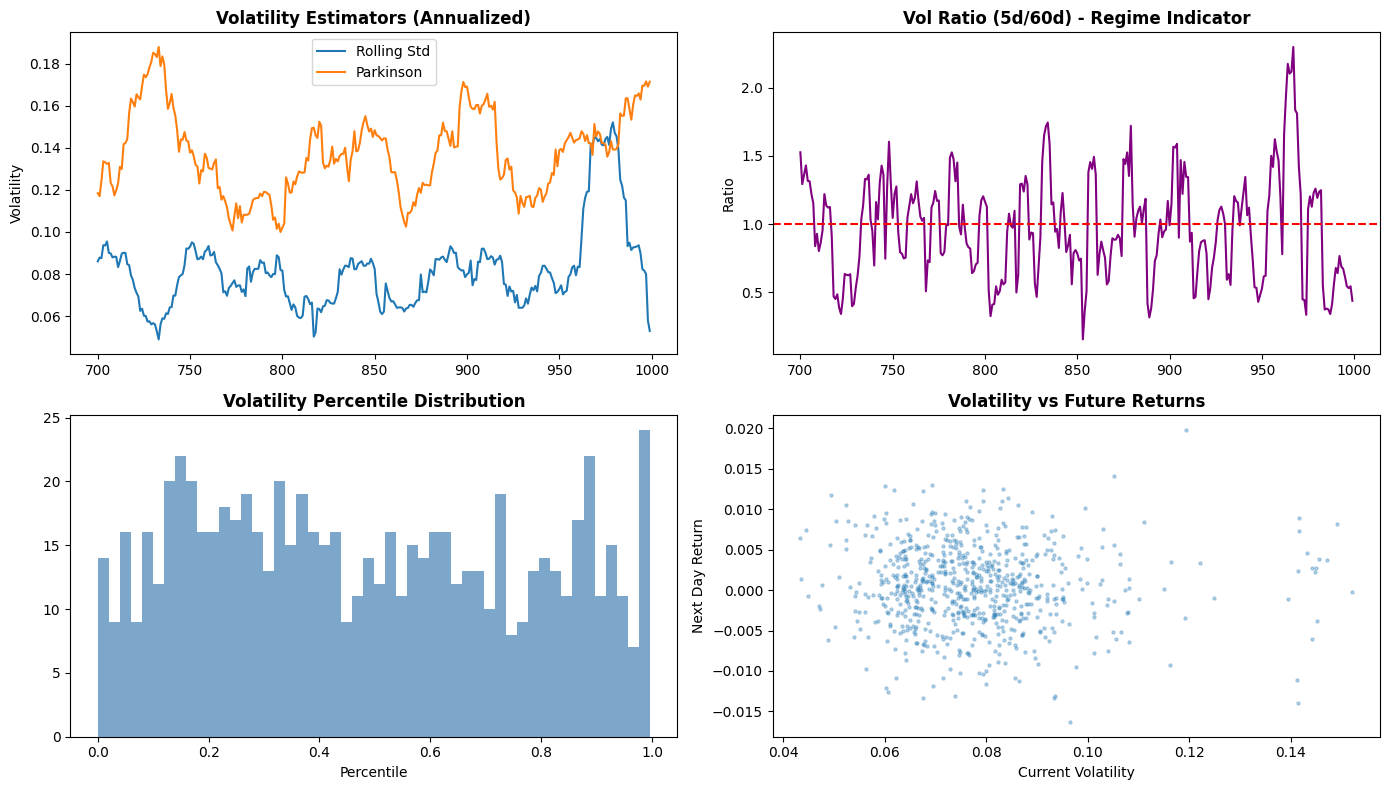

In [4]:
# ============================================================
# VISUALIZE VOLATILITY
# ============================================================

df_clean = df.dropna()

fig, axes = plt.subplots(2, 2, figsize=(14, 8))

axes[0, 0].plot(df_clean['vol_20d'].iloc[-300:], label='Rolling Std', linewidth=1.5)
axes[0, 0].plot(df_clean['parkinson_vol'].iloc[-300:], label='Parkinson', linewidth=1.5)
axes[0, 0].set_title('Volatility Estimators (Annualized)', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].set_ylabel('Volatility')

axes[0, 1].plot(df_clean['vol_ratio'].iloc[-300:], color='purple')
axes[0, 1].axhline(1, color='red', linestyle='--')
axes[0, 1].set_title('Vol Ratio (5d/60d) - Regime Indicator', fontweight='bold')
axes[0, 1].set_ylabel('Ratio')

axes[1, 0].hist(df_clean['vol_percentile'].dropna(), bins=50, alpha=0.7, color='steelblue')
axes[1, 0].set_xlabel('Percentile')
axes[1, 0].set_title('Volatility Percentile Distribution', fontweight='bold')

axes[1, 1].scatter(df_clean['vol_20d'], df_clean['returns'].shift(-1), alpha=0.3, s=5)
axes[1, 1].set_xlabel('Current Volatility')
axes[1, 1].set_ylabel('Next Day Return')
axes[1, 1].set_title('Volatility vs Future Returns', fontweight='bold')

plt.tight_layout()
plt.show()

## Part 2: Technical Indicators

In [5]:
# ============================================================
# TECHNICAL INDICATORS
# ============================================================

print("TECHNICAL INDICATORS")
print("="*60)

# RSI
def calculate_rsi(returns, period=14):
    gains = returns.where(returns > 0, 0).rolling(period).mean()
    losses = (-returns.where(returns < 0, 0)).rolling(period).mean()
    rs = gains / (losses + 1e-10)
    return 100 - (100 / (1 + rs))

df['rsi'] = calculate_rsi(df['returns'], 14)
df['rsi_normalized'] = (df['rsi'] - 50) / 50

# MACD
ema12 = df['close'].ewm(span=12).mean()
ema26 = df['close'].ewm(span=26).mean()
df['macd'] = ema12 - ema26
df['macd_signal'] = df['macd'].ewm(span=9).mean()
df['macd_hist'] = df['macd'] - df['macd_signal']
df['macd_normalized'] = df['macd'] / df['close']  # Percentage of price

# Bollinger Bands
ma20 = df['close'].rolling(20).mean()
std20 = df['close'].rolling(20).std()
df['bb_upper'] = ma20 + 2 * std20
df['bb_lower'] = ma20 - 2 * std20
df['bb_width'] = (df['bb_upper'] - df['bb_lower']) / ma20
df['bb_position'] = (df['close'] - df['bb_lower']) / (df['bb_upper'] - df['bb_lower'])

# Moving Average features
for period in [5, 10, 20, 50]:
    df[f'ma_{period}'] = df['close'].rolling(period).mean()
    df[f'ma_dist_{period}'] = df['close'] / df[f'ma_{period}'] - 1

# MA crossovers
df['ma_cross_5_20'] = df['ma_5'] / df['ma_20'] - 1
df['ma_cross_20_50'] = df['ma_20'] / df['ma_50'] - 1

print("Created technical indicators")

TECHNICAL INDICATORS
Created technical indicators


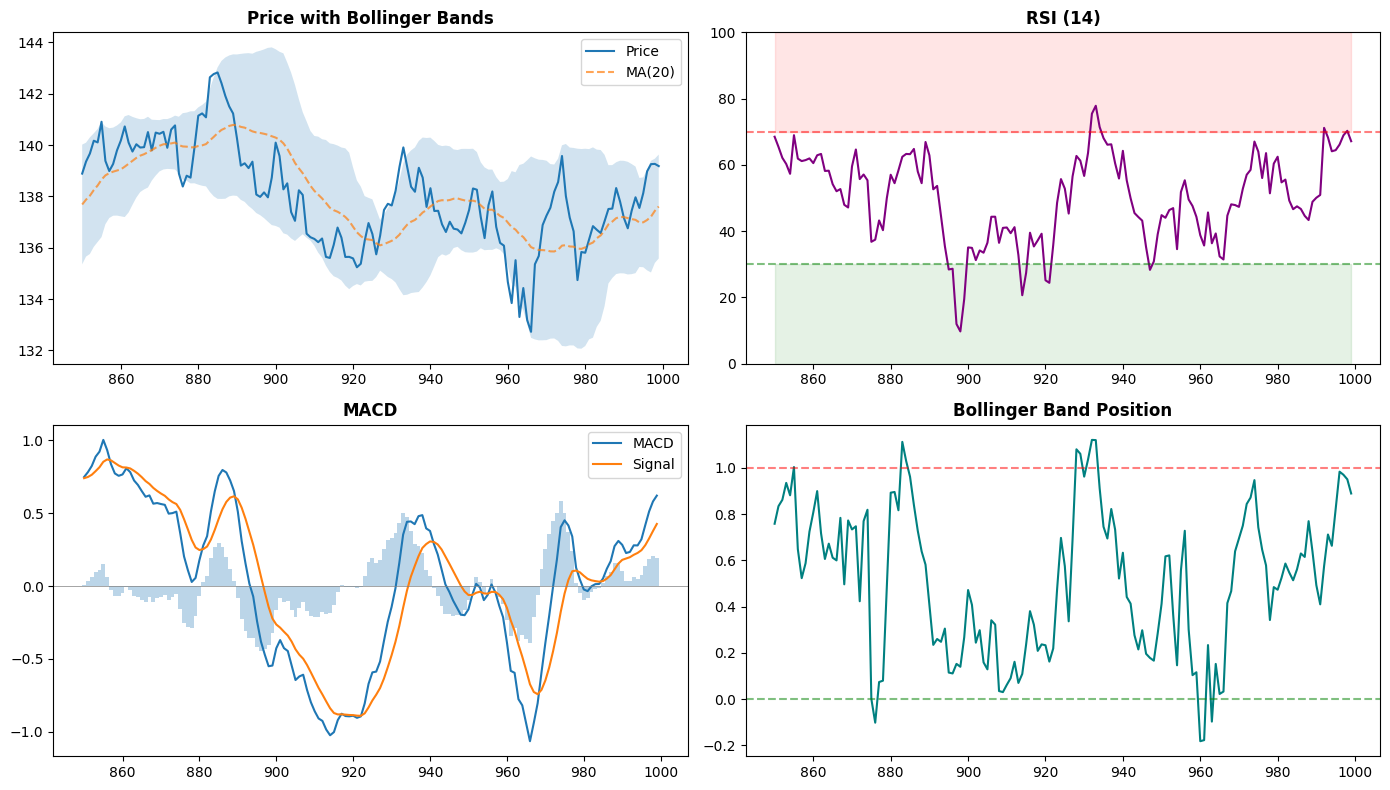

In [6]:
# ============================================================
# VISUALIZE TECHNICALS
# ============================================================

df_clean = df.dropna()

fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Price with Bollinger Bands
recent = df_clean.iloc[-150:]
axes[0, 0].plot(recent.index, recent['close'], label='Price', linewidth=1.5)
axes[0, 0].fill_between(recent.index, recent['bb_upper'], recent['bb_lower'], alpha=0.2)
axes[0, 0].plot(recent.index, recent['ma_20'], '--', label='MA(20)', alpha=0.7)
axes[0, 0].set_title('Price with Bollinger Bands', fontweight='bold')
axes[0, 0].legend()

# RSI
axes[0, 1].plot(recent['rsi'], color='purple')
axes[0, 1].axhline(70, color='red', linestyle='--', alpha=0.5)
axes[0, 1].axhline(30, color='green', linestyle='--', alpha=0.5)
axes[0, 1].fill_between(recent.index, 70, 100, alpha=0.1, color='red')
axes[0, 1].fill_between(recent.index, 0, 30, alpha=0.1, color='green')
axes[0, 1].set_title('RSI (14)', fontweight='bold')
axes[0, 1].set_ylim(0, 100)

# MACD
axes[1, 0].plot(recent['macd'], label='MACD', linewidth=1.5)
axes[1, 0].plot(recent['macd_signal'], label='Signal', linewidth=1.5)
axes[1, 0].bar(recent.index, recent['macd_hist'], alpha=0.3, width=1)
axes[1, 0].axhline(0, color='gray', linestyle='-', linewidth=0.5)
axes[1, 0].set_title('MACD', fontweight='bold')
axes[1, 0].legend()

# BB Position
axes[1, 1].plot(recent['bb_position'], color='teal')
axes[1, 1].axhline(1, color='red', linestyle='--', alpha=0.5)
axes[1, 1].axhline(0, color='green', linestyle='--', alpha=0.5)
axes[1, 1].set_title('Bollinger Band Position', fontweight='bold')

plt.tight_layout()
plt.show()

## Part 3: Volume Features

In [7]:
# ============================================================
# VOLUME FEATURES
# ============================================================

print("VOLUME FEATURES")
print("="*60)

# Volume averages
df['volume_ma5'] = df['volume'].rolling(5).mean()
df['volume_ma20'] = df['volume'].rolling(20).mean()
df['volume_ratio'] = df['volume'] / df['volume_ma20']

# On-Balance Volume
df['obv'] = (np.sign(df['returns']) * df['volume']).cumsum()
df['obv_ma'] = df['obv'].rolling(20).mean()
df['obv_divergence'] = (df['obv'] - df['obv_ma']) / df['volume_ma20']

# Price-Volume trend
df['pv_trend'] = df['close'].rolling(20).corr(df['volume'])

# VWAP
df['vwap_20'] = (df['close'] * df['volume']).rolling(20).sum() / df['volume'].rolling(20).sum()
df['vwap_distance'] = df['close'] / df['vwap_20'] - 1

print("Created volume features:")
for col in ['volume_ratio', 'obv_divergence', 'pv_trend', 'vwap_distance']:
    print(f"  • {col}")

VOLUME FEATURES
Created volume features:
  • volume_ratio
  • obv_divergence
  • pv_trend
  • vwap_distance


In [8]:
# ============================================================
# FEATURE SUMMARY
# ============================================================

feature_cols = [c for c in df.columns if c not in ['close', 'open', 'high', 'low', 'volume', 'returns', 'obv']]
feature_cols = [c for c in feature_cols if not c.startswith('ma_') or 'dist' in c or 'cross' in c]

print(f"\nTotal features created: {len(feature_cols)}")
print("\nFeature categories:")
print(f"  Volatility: {len([c for c in feature_cols if 'vol' in c])}")
print(f"  Technical: {len([c for c in feature_cols if 'rsi' in c or 'macd' in c or 'bb' in c])}")
print(f"  Volume: {len([c for c in feature_cols if 'volume' in c or 'obv' in c or 'vwap' in c or 'pv_' in c])}")


Total features created: 33

Feature categories:
  Volatility: 12
  Technical: 10
  Volume: 8


In [9]:
print("""
╔══════════════════════════════════════════════════════════════════╗
║         DAY 2 COMPLETE: VOLATILITY & TECHNICAL FEATURES          ║
╠══════════════════════════════════════════════════════════════════╣
║  ✓ Rolling volatility at multiple horizons                      ║
║  ✓ Parkinson & Garman-Klass (range-based)                       ║
║  ✓ Vol-of-vol and vol percentile                                ║
║  ✓ RSI, MACD, Bollinger Bands                                   ║
║  ✓ Volume features: OBV, VWAP, ratios                           ║
╚══════════════════════════════════════════════════════════════════╝

Tomorrow: Day 3 - Feature Selection Methods
""")


╔══════════════════════════════════════════════════════════════════╗
║         DAY 2 COMPLETE: VOLATILITY & TECHNICAL FEATURES          ║
╠══════════════════════════════════════════════════════════════════╣
║  ✓ Rolling volatility at multiple horizons                      ║
║  ✓ Parkinson & Garman-Klass (range-based)                       ║
║  ✓ Vol-of-vol and vol percentile                                ║
║  ✓ RSI, MACD, Bollinger Bands                                   ║
║  ✓ Volume features: OBV, VWAP, ratios                           ║
╚══════════════════════════════════════════════════════════════════╝

Tomorrow: Day 3 - Feature Selection Methods

